In [1]:
print("hi there")

hi there


In [32]:
from dotenv import load_dotenv
load_dotenv()
from langchain_google_genai import GoogleGenerativeAI
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.0-flash")


In [33]:
from langgraph.graph import StateGraph, END, START, StateGraph, MessagesState
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [34]:
@tool
def get_weather(city: str) -> str:
    """call this tool to get the weather of a city"""
    if city.lower() == "mumbai":
        return "22 degree celsius"
    elif city.lower() == "delhi":
        return "24 degree celsius"
    else:
        return "I don't know the weather of this city"
    

In [36]:
get_weather.invoke("Mumbai") # this is runable due to @tool decorator

'22 degree celsius'

In [37]:
tools=[get_weather]
def call_model(state: MessagesState):
    messages=state["messages"]
    response=llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"  # Return the string name of the tool node
    else:
        return "end"


In [38]:
llm_with_tools = llm.bind_tools(tools)

In [39]:
workflow=StateGraph(MessagesState)
tool_node=ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

In [40]:

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",should_continue,
    {'tools': 'tool',
      'end': END}
      )

workflow.add_edge("tool", "agent")




In [41]:
graph=workflow.compile()

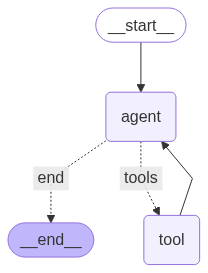

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ))
)

In [43]:
from langchain_core.messages import HumanMessage

messages=[HumanMessage(content="What is the weather in Mumbai?")]
messages1=[HumanMessage(content="hello how are you?")]  

In [44]:
graph.invoke({"messages":messages})

{'messages': [HumanMessage(content='What is the weather in Mumbai?', additional_kwargs={}, response_metadata={}, id='793b03a4-e5d7-4e53-b6f8-bf7f7f2acd93'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Mumbai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--edcd163c-2de7-478d-af2c-0519043e0768-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Mumbai'}, 'id': '1b7e3952-855e-476a-a001-d5ab51998ee2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 24, 'output_tokens': 5, 'total_tokens': 29, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='22 degree celsius', name='get_weather', id='d9ef1bb1-fbdc-4c8e-ae13-91675dd70763', tool_call_id='1b7e3952-855e-476a-a001-d5ab51998ee2'),
  AIMessage(content='The weather in Mumbai is 22 degree celsius.', additional_kwargs={}, respons

In [45]:
graph.invoke({"messages":messages1})

{'messages': [HumanMessage(content='hello how are you?', additional_kwargs={}, response_metadata={}, id='b23ac6aa-beee-4bf4-9257-4fd74b307c28'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--52ff9dcd-2e55-4c79-99de-2d7354f06580-0', usage_metadata={'input_tokens': 22, 'output_tokens': 18, 'total_tokens': 40, 'input_token_details': {'cache_read': 0}})]}

## Note that we dont have memory in above case so we can't ask any follow up question.

In [77]:
#for adding memory to the agent
from langgraph.checkpoint.memory import MemorySaver

checkpointer=MemorySaver()

workflow=StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {'tools': 'tools',
      'end': END},
)
workflow.add_edge("tools", "agent")

graph=workflow.compile(checkpointer=checkpointer)

#graph.invoke({"messages": [HumanMessage(content="What is the weather in Tokyo?")]})



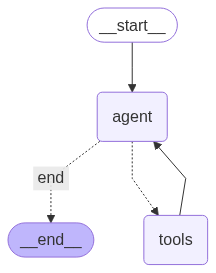

In [81]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ))
)

In [78]:
user_input=" I am in Mumbai What is the weather here?"

In [79]:
#user_input = "Hi there! My name is Will."
graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "4"}},
)


{'messages': [HumanMessage(content=' I am in Mumbai What is the weather here?', additional_kwargs={}, response_metadata={}, id='ad25446b-238d-4457-a66c-7237ad207cd3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Mumbai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--049ae94c-b724-4e07-9a19-e30362f5f0e3-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Mumbai'}, 'id': '7e1ffe7a-3e2e-4530-8541-927f5e198e0b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 27, 'output_tokens': 5, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='22 degree celsius', name='get_weather', id='0a4f2aab-909a-49f3-aeb5-dd80ae7fd7d1', tool_call_id='7e1ffe7a-3e2e-4530-8541-927f5e198e0b'),
  AIMessage(content='The weather in Mumbai is 22 degree celsius.', additional_kwargs=

In [80]:
user_input = "do I need to wear a jacket today?"
graph.invoke(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "4"}},
)


{'messages': [HumanMessage(content=' I am in Mumbai What is the weather here?', additional_kwargs={}, response_metadata={}, id='ad25446b-238d-4457-a66c-7237ad207cd3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Mumbai"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--049ae94c-b724-4e07-9a19-e30362f5f0e3-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Mumbai'}, 'id': '7e1ffe7a-3e2e-4530-8541-927f5e198e0b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 27, 'output_tokens': 5, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='22 degree celsius', name='get_weather', id='0a4f2aab-909a-49f3-aeb5-dd80ae7fd7d1', tool_call_id='7e1ffe7a-3e2e-4530-8541-927f5e198e0b'),
  AIMessage(content='The weather in Mumbai is 22 degree celsius.', additional_kwargs=

In [72]:
print(len(events))

1


In [58]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.invoke(
    {"messages": messages},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[2].parts: contents.parts must not be empty.


In [55]:
graph.invoke({"messages": messages},
             config={"configurable": {"thread_id": 1}})




ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents[2].parts: contents.parts must not be empty.
